# Importing all the libraries here 

In [ ]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import decomposition
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from sklearn.decomposition import TruncatedSVD, FastICA, NMF, FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV


from sklearn.manifold import TSNE

from sklearn.decomposition import KernelPCA, PCA



# Importing all the Datasets
#### These are the imputed datasets

In [2]:
df_train = pd.read_csv("ProcessedWeatherData_v5.csv")
df_test = pd.read_csv("ProcessedWeatherDataTest_v5.csv")
df_train.head()
df_test.shape

(21996, 11)

##### Correlation of the Dataset is checked to see what features are relevant

In [3]:
df_train.corr()

,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity
AtmosphericPressure,1.000000,-0.076168,-0.388719,-0.420284,-0.429898,-0.250961,0.018300,-0.020685,-0.013369,-0.064759
WindDirection,-0.076168,1.000000,0.117028,0.139023,0.190930,0.133636,0.099881,0.036790,0.137088,-0.070592
WindSpeed,-0.388719,0.117028,1.000000,0.957870,0.631274,0.207663,-0.031589,0.013113,-0.082022,0.065650
Gust,-0.420284,0.139023,0.957870,1.000000,0.715752,0.305819,-0.089816,-0.047670,-0.106682,0.023505
WaveHeight,-0.429898,0.190930,0.631274,0.715752,1.000000,0.802946,-0.168678,-0.170746,-0.174221,-0.113491
WavePeriod,-0.250961,0.133636,0.207663,0.305819,0.802946,1.000000,-0.166358,-0.193637,-0.166830,-0.159426
AirTemperature,0.018300,0.099881,-0.031589,-0.089816,-0.168678,-0.166358,1.000000,0.900933,0.867535,0.431830
DewPoint,-0.020685,0.036790,0.013113,-0.047670,-0.170746,-0.193637,0.900933,1.000000,0.695651,0.779350
SeaTemperature,-0.013369,0.137088,-0.082022,-0.106682,-0.174221,-0.166830,0.867535,0.695651,1.000000,0.193094
RelativeHumidity,-0.064759,-0.070592,0.065650,0.023505,-0.113491,-0.159426,0.431830,0.779350,0.193094,1.000000


##### Drop all the Features that are not going to be used.
##### Since we are dealing with Feature Set 1 (AtmosphericPressur, WindSpeed, AirTemperatue, DewPoint, SeaTemperature and Realitive Humidity are Kept)

In [6]:
df_train.drop(["station_id","WindDirection","Gust","WaveHeight", "WaveHeight","WavePeriod"],inplace = True, axis = 1)
df_test.drop(["station_id","WindDirection","Gust","WaveHeight", "WaveHeight","WavePeriod"],inplace = True, axis = 1)
df_train.head()

,AtmosphericPressure,WindSpeed,AirTemperature,DewPoint,SeaTemperature,RelativeHumidity
0,1011.4,18.0,16.2,13.9,16.1,86.0
1,1023.3,11.0,13.9,11.0,14.9,83.0
2,1033.2,19.0,7.7,4.0,10.2,77.0
3,1012.5,13.0,14.7,14.0,15.6,96.0
4,1011.0,13.0,13.6,10.7,13.9,83.0


### Here we display the Target Variable vs the features selected 

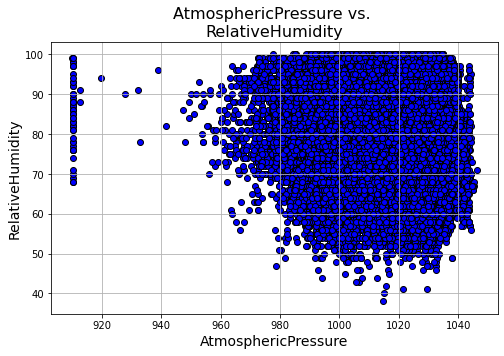

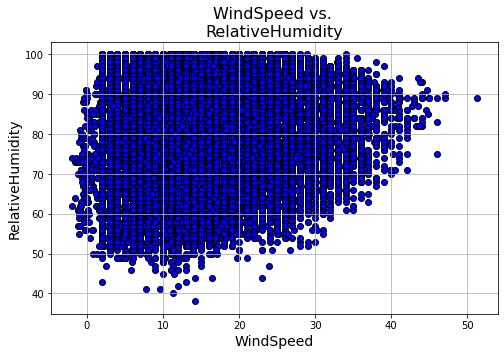

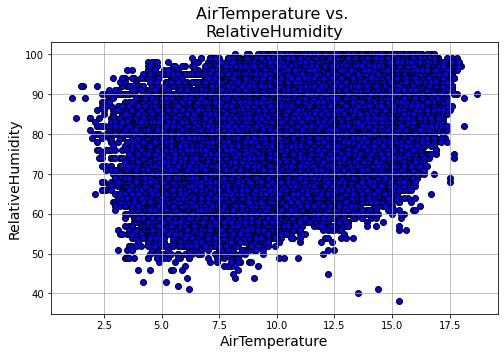

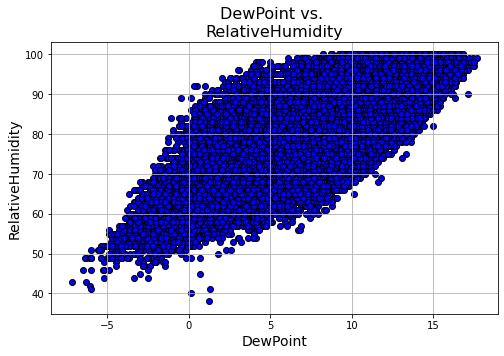

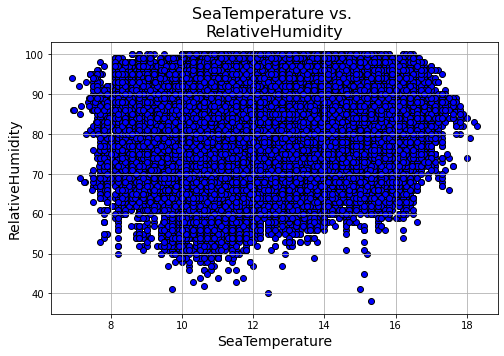

In [7]:
for c in df_train.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nRelativeHumidity".format(c),fontsize=16)
    plt.scatter(x=df_train[c],y=df_train['RelativeHumidity'],color='blue',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('RelativeHumidity',fontsize=14)
    plt.show()

#### Here a Custom Scaler is used that was developed with other iterations of the data set 
#### specifially for fitting the target variable and the Xtrain separately and for Data Extraction methods which were PCA,ICA

In [6]:
X_train_unscaled = df_train.iloc[:,: -1].values
y_train_unscaled = df_train.iloc[:, -1].values
X_test_unscaled = df_test.iloc[:, :-1].values
y_test_unscaled = df_test.iloc[:, -1].values
print(X_train_unscaled.shape)

class CustomScaler():
    
        def __init__(self, X_Scale, y_Scale ) :
        
            self.X_Scale =   X_Scale 
            self.y_Scale =   y_Scale
            
            self.x_num =     [np.mean(self.X_Scale[:,i]) for i in range(self.X_Scale.shape[1])]
            self.x_maxs =    [np.max(self.X_Scale[:,i]) for i in range(self.X_Scale.shape[1])]
            self.x_mins =    [np.min(self.X_Scale[:,i]) for i in range(self.X_Scale.shape[1])]
            
            self.y_num =     np.mean(self.y_Scale)
            self.y_max_min = np.max(self.y_Scale) - np.min(self.y_Scale)

        def scaleX(self, x_value):
            x = x_value.copy()
            for i in range(x.shape[1]):
                
                x[:,i]= (x[:,i] - self.x_num[i])/(self.x_maxs[i]-self.x_mins[i])
            return x

        def inverseScaleX(self, x_value):
            x = x_value.copy()
            
            for i in range(x.shape[1]):
                x[:,i]= (x[:,i] * (self.x_maxs[i]-self.x_mins[i])) + self.x_num[i]
            return x



        

        def scaleY(self, y_value):
            y = y_value.copy()
            ys = (y - self.y_num)/(self.y_max_min)
            return ys

        def inverseScaleY(self, y_value):
            y = y_value.copy()
            ys = (y * self.y_max_min) + self.y_num
            return ys


        



custom_scaler = CustomScaler(X_train_unscaled,y_train_unscaled)
    
X_train = custom_scaler.scaleX(X_train_unscaled.copy())
y_train = custom_scaler.scaleY(y_train_unscaled.copy())
transform = None


print(X_train[-70000: -1])

print(X_test_unscaled[:10,:],y_test_unscaled[:10])



(87983, 5)
[[ 0.05449026 -0.25085742 -0.06839196  0.01437486 -0.07659381]
 [-0.03342183  0.08658579  0.22138077  0.19911381  0.23020606]
 [-0.13159033 -0.06338897  0.18160804  0.21919413  0.17118114]
 ...
 [ 0.12775033 -0.15712319 -0.27293741 -0.24666932 -0.35709654]
 [-0.01437421  0.06783895  0.03388077  0.09871221 -0.09412523]
 [-0.13305553  0.13900713 -0.03998287 -0.06193036 -0.10289094]]
[[1.01960000e+03 1.73318206e+01 9.80000000e+00 6.20000000e+00
  1.08000000e+01]
 [1.00130000e+03 2.50000000e+01 9.80000000e+00 6.20000000e+00
  1.05000000e+01]
 [1.01920000e+03 1.91277467e+01 1.31000000e+01 9.90000000e+00
  1.43000000e+01]
 [1.02400000e+03 1.60000000e+01 7.50000000e+00 3.60000000e+00
  9.70635015e+00]
 [1.00560000e+03 1.90000000e+01 7.80000000e+00 5.00000000e-01
  9.70000000e+00]
 [1.01600000e+03 1.47115860e+01 1.21000000e+01 1.11000000e+01
  1.11000000e+01]
 [1.00290000e+03 3.30000000e+01 1.10000000e+01 1.00000000e+01
  1.14000000e+01]
 [1.01730000e+03 1.70000000e+01 1.54000000e+0

## Here the Neural Network Model a Multi Layer Perceptron is Configured 
## Cross Val is the commented out section which was used for validation of the network. 

In [7]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.7,
    beta_2=0.88,
    epsilon=1e-07,
    amsgrad=False,)

def build_model(optimizer="sgd", activation = 'relu'):    
    model = keras.Sequential()
    model.add(Dense(500 ,activation = activation,input_dim = X_train.shape[1], name = "layer1"))
    model.add(Dense(1000, activation = activation, name = "layer2"))
    model.add(Dense(1000 ,activation = activation, name = "layer3"))
    model.add(Dense(500 ,activation = activation, name = "layer4"))

   
    model.add(Dense(1, name = "layer7"))
    model.compile(loss="mean_squared_error", optimizer=opt)
    return model


# es = EarlyStopping(monitor='val_loss', mode='max', verbose=1)

regression_model = KerasRegressor(build_fn=build_model, epochs=500, batch_size=1024,validation_split=0.2,  verbose=1)
history=regression_model.fit(X_train, y_train)


# from sklearn.model_selection import cross_val_score
# regressor = KerasRegressor(build_fn = build_model, batch_size = 1024, epochs = 100)
# accuracies = cross_val_score(estimator = regressor, X = X_train, y = y_train,scoring='neg_mean_squared_error',cv = 5, n_jobs = 1)
# mean = accuracies.mean()
# variance = accuracies.std()
# print(mean)
# print(variance)



Epoch 1/500
69/69 [==============================] - 1s 21ms/step - loss: 0.0028 - val_loss: 9.2389e-05
Epoch 2/500
69/69 [==============================] - 1s 16ms/step - loss: 3.7693e-04 - val_loss: 0.0012
Epoch 3/500
69/69 [==============================] - 1s 17ms/step - loss: 3.0614e-04 - val_loss: 6.5907e-05
Epoch 4/500
69/69 [==============================] - 1s 17ms/step - loss: 2.1154e-04 - val_loss: 1.5788e-04
Epoch 5/500
69/69 [==============================] - 1s 16ms/step - loss: 1.7777e-04 - val_loss: 1.6197e-04
Epoch 6/500
69/69 [==============================] - 1s 17ms/step - loss: 1.5030e-04 - val_loss: 1.1273e-04
Epoch 7/500
69/69 [==============================] - 1s 17ms/step - loss: 1.4222e-04 - val_loss: 6.1690e-05
Epoch 8/500
69/69 [==============================] - 1s 17ms/step - loss: 1.2964e-04 - val_loss: 5.0110e-04
Epoch 9/500
69/69 [==============================] - 1s 17ms/step - loss: 1.3325e-04 - val_loss: 7.7267e-05
Epoch 10/500
69/69 [================

Epoch 151/500
69/69 [==============================] - 1s 12ms/step - loss: 3.0340e-05 - val_loss: 2.1640e-05
Epoch 152/500
69/69 [==============================] - 1s 11ms/step - loss: 3.0587e-05 - val_loss: 3.8266e-05
Epoch 153/500
69/69 [==============================] - 1s 11ms/step - loss: 2.9071e-05 - val_loss: 2.4806e-05
Epoch 154/500
69/69 [==============================] - 1s 11ms/step - loss: 2.8685e-05 - val_loss: 2.6650e-05
Epoch 155/500
69/69 [==============================] - 1s 11ms/step - loss: 2.9641e-05 - val_loss: 2.1662e-05
Epoch 156/500
69/69 [==============================] - 1s 11ms/step - loss: 2.8350e-05 - val_loss: 2.3580e-05
Epoch 157/500
69/69 [==============================] - 1s 12ms/step - loss: 2.9425e-05 - val_loss: 2.3277e-05
Epoch 158/500
69/69 [==============================] - 1s 12ms/step - loss: 2.8850e-05 - val_loss: 3.9253e-05
Epoch 159/500
69/69 [==============================] - 1s 12ms/step - loss: 2.9185e-05 - val_loss: 2.5109e-05
Epoch 160/

69/69 [==============================] - 1s 11ms/step - loss: 1.8295e-05 - val_loss: 1.2492e-05
Epoch 300/500
69/69 [==============================] - 1s 12ms/step - loss: 2.0695e-05 - val_loss: 1.3446e-05
Epoch 301/500
69/69 [==============================] - 1s 13ms/step - loss: 1.8966e-05 - val_loss: 1.3144e-05
Epoch 302/500
69/69 [==============================] - 1s 12ms/step - loss: 1.8262e-05 - val_loss: 1.7871e-05
Epoch 303/500
69/69 [==============================] - 1s 12ms/step - loss: 1.7125e-05 - val_loss: 1.3673e-05
Epoch 304/500
69/69 [==============================] - 1s 13ms/step - loss: 1.7778e-05 - val_loss: 1.9737e-05
Epoch 305/500
69/69 [==============================] - 1s 13ms/step - loss: 1.7179e-05 - val_loss: 1.5600e-05
Epoch 306/500
69/69 [==============================] - 1s 11ms/step - loss: 1.8616e-05 - val_loss: 2.1254e-05
Epoch 307/500
69/69 [==============================] - 1s 11ms/step - loss: 1.7785e-05 - val_loss: 1.4478e-05
Epoch 308/500
69/69 [===

69/69 [==============================] - 1s 12ms/step - loss: 1.3424e-05 - val_loss: 8.3530e-06
Epoch 448/500
69/69 [==============================] - 1s 12ms/step - loss: 1.2419e-05 - val_loss: 1.6810e-05
Epoch 449/500
69/69 [==============================] - 1s 12ms/step - loss: 1.2048e-05 - val_loss: 1.2582e-05
Epoch 450/500
69/69 [==============================] - 1s 12ms/step - loss: 1.2424e-05 - val_loss: 1.2017e-05
Epoch 451/500
69/69 [==============================] - 1s 12ms/step - loss: 1.2207e-05 - val_loss: 8.0314e-06
Epoch 452/500
69/69 [==============================] - 1s 12ms/step - loss: 1.2386e-05 - val_loss: 1.5997e-05
Epoch 453/500
69/69 [==============================] - 1s 12ms/step - loss: 1.2085e-05 - val_loss: 8.0637e-05
Epoch 454/500
69/69 [==============================] - 1s 12ms/step - loss: 1.2674e-05 - val_loss: 8.9809e-06
Epoch 455/500
69/69 [==============================] - 1s 12ms/step - loss: 1.3866e-05 - val_loss: 8.0951e-06
Epoch 456/500
69/69 [===

### Here we test the model on De Normalized Predictions using the custom scaler with the test set 

In [8]:
from sklearn.metrics import mean_squared_error
transformer = None
if transformer:
    y_pred = regression_model.predict(transformer.transform(custom_scaler.scaleX(np.asarray(X_test_unscaled).astype('float32'))))
else :
    y_pred = regression_model.predict((custom_scaler.scaleX(np.asarray(X_test_unscaled).astype('float32'))))

# y_pred = max_min*y_pred + y_min
y_pred_unscaled = custom_scaler.inverseScaleY(y_pred)

print(mean_squared_error(custom_scaler.inverseScaleY(y_pred), y_test_unscaled))

22/22 [==============================] - 0s 4ms/step
0.032128166967940804


### Here other Metrics used in the model are used

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, max_error
r2 = r2_score(y_pred_unscaled, y_test_unscaled)
mae = mean_absolute_error(y_pred_unscaled, y_test_unscaled)
me =  max_error(y_pred_unscaled, y_test_unscaled)
adj_r2 = 1 - (1-r2)*(len(y_test_unscaled)-1)/(len(y_test_unscaled)-X_test_unscaled.shape[1]-1)
print("R squred is ",r2)
print("Mean Absolute Error is ",mae)
print("Max Error is ",me)
print("Adjusted R squred is ",adj_r2)

R squred is  0.9997109056897392
Mean Absolute Error is  0.10887840605363085
Max Error is  5.9170989990234375
Adjusted R squred is  0.9997108399566081


## 2 Plots 1. Model Loss while Training 2. Residual Plot are shown below

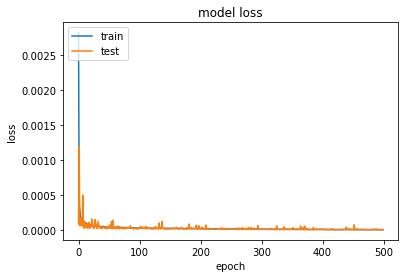

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

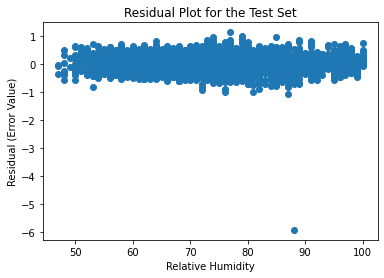

In [17]:
residual = y_test_unscaled - y_pred_unscaled
# sns.regplot(x = residual, y = y_test_unscaled, data = None, scatter = True, color = 'red')
plt.scatter(y_test_unscaled, residual)
plt.title("Residual Plot for the Test Set")
plt.xlabel("Relative Humidity")
plt.ylabel("Residual (Error Value)")
plt.show()

## The Predicted De Normalized and Un Sclaed Predictions and True Test target Values are shown together for Comparison

In [18]:
np.column_stack((y_test_unscaled,custom_scaler.inverseScaleY(y_pred)))

array([[78.        , 77.95718384],
       [78.        , 77.96392059],
       [81.        , 80.97460938],
       ...,
       [68.        , 68.42037964],
       [89.        , 88.94532013],
       [73.        , 72.94599915]])

# Here We Try and Test Our Model on Live Unseen Data Collected for the 21st OF December 2020

In [12]:
df_unseen = pd.read_csv("UnseenTest.csv")

In [13]:
df_unseen.head()

,ID,name,wmoID,time,pressure,windDir,windSpeed,windGust,temp,dewPoint,humidity,period,height,seaTemp,reportDate,reportTime,updated_At,created_at
0,444313,M5,62094,19 Dec 11:00,995.3,212,46,61,10.8,6.7,76,7.3,4.5,11.0,19-12-2020,11:00,2020-12-19 12:15:28,2020-12-19 12:15:28
1,444325,M5,62094,19 Dec 12:00,995.4,220,48,61,11.2,6.7,74,7.3,4.3,11.0,19-12-2020,12:00,2020-12-19 12:21:06,2020-12-19 12:21:06
2,444343,M5,62094,19 Dec 13:00,996.2,235,48,65,10.6,4.9,68,7.4,4.5,11.1,19-12-2020,13:00,2020-12-19 13:21:06,2020-12-19 13:21:06
3,444361,M5,62094,19 Dec 14:00,997.2,249,37,-,9.5,5.5,76,7.3,4.5,11.0,19-12-2020,14:00,2020-12-19 14:21:22,2020-12-19 14:21:22
4,444385,M5,62094,19 Dec 15:00,997.5,242,24,-,9.3,6.6,83,7.9,4.6,11.0,19-12-2020,15:00,2020-12-19 15:20:32,2020-12-19 15:20:32


In [21]:
x_unseen =df_unseen[["pressure","windSpeed","temp","dewPoint","seaTemp"]].values
y_unseen = df_unseen["humidity"].values

In [14]:
unseen_out = regression_model.predict((custom_scaler.scaleX(np.asarray(x_unseen).astype('float32'))))
unseen_out_unscaled = custom_scaler.inverseScaleY(unseen_out)
unseen_out_unscaled

NameError: name 'regression_model' is not defined

## Metrics for the new unseen data

In [15]:
print(mean_squared_error(unseen_out_unscaled, y_unseen))

NameError: name 'mean_squared_error' is not defined

In [16]:
from sklearn.metrics import r2_score
r2 = r2_score(unseen_out_unscaled, y_unseen)
adj_r2 = 1 - (1-r2)*(len(y_unseen)-1)/(len(y_unseen)-x_unseen.shape[1]-1)

NameError: name 'unseen_out_unscaled' is not defined

In [25]:
adj_r2

0.9990185452686051

In [26]:
from sklearn.metrics import max_error
max_error(unseen_out_unscaled, y_unseen)

0.33643341064453125

In [27]:
residuals = y_unseen - unseen_out_unscaled

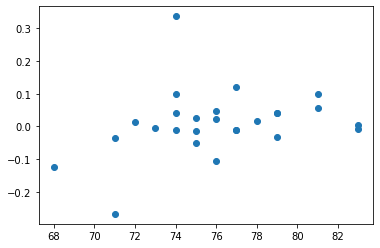

In [28]:
residuals.shape
plt.scatter(y_unseen, residuals)

plt.show()

## Comparing the Predictions vs the Unseen Data Values

In [30]:
np.column_stack((y_unseen, unseen_out_unscaled))

array([[76.        , 75.95394135],
       [74.        , 73.66356659],
       [68.        , 68.12487793],
       [76.        , 76.10517883],
       [83.        , 83.00814056],
       [75.        , 75.05007935],
       [77.        , 77.01210022],
       [73.        , 73.00546265],
       [71.        , 71.2668457 ],
       [77.        , 76.87828827],
       [76.        , 75.9756546 ],
       [75.        , 75.01418304],
       [83.        , 82.99555969],
       [74.        , 74.01223755],
       [81.        , 80.94417572],
       [81.        , 80.90158081],
       [79.        , 78.95769501],
       [77.        , 77.01071167],
       [79.        , 78.95818329],
       [75.        , 74.97263336],
       [74.        , 73.90117645],
       [78.        , 77.9821167 ],
       [79.        , 79.03149414],
       [71.        , 71.0338974 ],
       [74.        , 73.95967865],
       [72.        , 71.98509216]])